# Logistic regression

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter introduces two related topics: log odds and logistic regression.

In Chapter 5, we rewrote Bayes's Theorem in terms of odds and derived Bayes's Rule, which can be a convenient way to do a Bayesian update on paper or in your head.
In this chapter, we'll look at Bayes's Rule on a logarithmic scale, which provides insight into how we accumulate evidence through successive updates.

That leads directly to logistic regression, which is based on a linear model of the relationship between evidence and the log odds of a hypothesis.  
We'll use data from the Space Shuttle to explore the relationship between temperature and the probability of damage to the O-rings.  Then we'll use data from the General Social Survey to explore generational changes in support for legalizing marijuana.  

As an exercise, you'll have a chance to model the relationship between a child's age when they start school and their probability of being diagnosed with Attention Deficit Hyperactivity Disorder (ADHD).

## Log odds

When I was in grad school, I signed up for a class on Theory of Computation. 
On the first day of class, I was the first to arrive. 
A few minutes later, another student arrived. 
Because most students in the computer science program were male, I was mildly surprised that the other student was female.

Another female student arrived a few minutes later, which was sufficiently surprising that I started to think I was in the wrong room. 
When third female student arrived, I was confident I was in the wrong place.
As it turned out, I was.

As each student arrived, I used the observed data to update my belief that I was in the right place. We can use Bayes's Rule, which we saw in Chapter 5, to quantify the calculation I was doing intuitively.

I'll use $H$ to represent the hypothesis that I was in the right room, and $F$ to represent the observation that the first other student was female. Bayes's Rule gives us:

$$O(H|F) = O(H) \frac{P(F|H)}{P(F|not H)}$$

Before I saw the other students, I was confident I was in the right room, so I might assign prior odds of 10:1 in favor:

$$O(H) = 10$$

At the time, advanced computer science classes were about 90% male, so if I was in the right room, the likelihood of the first female student was only 10%.

If I was not in the right room, the likelihood of the first female student was more like 50%, so the likelihood ratio is 1/5.  Applying Bayes's Rule:

$$O(H|F) = O(H) / 5 = 2$$

After the first student, the posterior odds are 2:1 I was in the right room.  
After two students:

$$O(H|FF) = O(H) / 25 = 2/5$$

The posterior odds were 2/5, and after three students:

$$O(H|FFF) = 2/25$$

The posterior odds were 2/25.
At that point, I was right to believe I was in the wrong room.

Let's see what those odds look like in terms of probability.
Here's the function we used in Chapter 6 to convert odds to probability.

In [4]:
def prob(o):
    return o / (o+1)

The following table shows the odds after each update, the corresponding probabilities, and the change in probability after each step, expressed in percentage points.

In [5]:
import pandas as pd

index = ['prior', '1 student', '2 students', '3 students']

table = pd.DataFrame(index=index)
table['odds'] = [10, 2, 2/5, 2/25]
table['prob'] = prob(table['odds'])
table['prob diff'] = table['prob'].diff() * 100

table.fillna('--')

,odds,prob,prob diff
prior,10.00,0.909091,--
1 student,2.00,0.666667,-24.2424
2 students,0.40,0.285714,-38.0952
3 students,0.08,0.074074,-21.164


Each update uses the same likelihood, but the changes in probability are not the same.  The first update decreases the probability by about 24 percentage points, the second by 38, and the third by 21.

That's normal for this kind of update, and in fact it's necessary; if the changes were the same size, we would quickly get negative probabilities.

The odds follow a more obvious pattern.  Because each update multiplies the odds by the same likelihood ratio, the odds form a geometric sequence.

And that brings us to consider another way to represent uncertainty: **log odds**, which is the logarithm of odds, usually expressed using the natural log (base $e$).

Adding log odds to the table:

In [6]:
import numpy as np

table['log odds'] = np.log(table['odds'])
table['log odds diff'] = table['log odds'].diff()

table.fillna('--')

,odds,prob,prob diff,log odds,log odds diff
prior,10.00,0.909091,--,2.302585,--
1 student,2.00,0.666667,-24.2424,0.693147,-1.60944
2 students,0.40,0.285714,-38.0952,-0.916291,-1.60944
3 students,0.08,0.074074,-21.164,-2.525729,-1.60944


You might notice:

* When probability is greater than 0.5, odds are greater than 1, and log odds are positive.

* When probability is less than 0.5, odds are less than 1, and log odds are negative.

You might also notice that the log odds are equally spaced.
The change in log odds after each update is the logarithm of the likelihood ratio.

In [7]:
np.log(1/5)

-1.6094379124341003

That's true in this example, and we can show that it's true in general by taking the log of both sides of Bayes's Rule.

$$\log O(H|F) = \log O(H) + \log \frac{P(F|H)}{P(F|not H)}$$

On a log odds scale, a Bayesian update is additive.  So if $F^x$ means that $x$ female students arrive while I am waiting, the posterior log odds that I am in the right room are:

$$\log O(H|F^x) = \log O(H) + x \log \frac{P(F|H)}{P(F|not H)}$$

This equation represents a linear relationship between the evidence and the posterior log odds.  

In this example the linear equation is correct, but even when it's not, it is common to use a linear function to model the relationship between an explanatory variable, $x$, and a dependent variable expressed in log odds, like this:

$$\log O(H | x) = \beta_0 + \beta_1 x$$

where $\beta_0$ and $\beta_1$ are unknown parameters:

* The intercept, $\beta_0$, is the log odds of the hypothesis when $x$ is 0.

* The slope, $\beta_1$, is the log of the likelihood ratio.

This equation is the basis of logistic regression.

## The Space Shuttle problem

As an example of logistic regression, I'll solve a problem from Cameron Davidson-Pilon's book, [Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb).  He writes:

> "On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23 (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend."

The dataset is originally from [this paper](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1989.10478858), but we can download it from Davidson-Pilon's site.

In [8]:
import os

if not os.path.exists('challenger_data.csv'):
    !wget https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv

I'll read the data and do a little cleaning.

In [9]:
data = pd.read_csv('challenger_data.csv', parse_dates=[0])

# avoiding column names with spaces
data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

# dropping row 3, in which Damage Incident is NaN,
# and row 24, which is the record for the Challenger
data.drop(labels=[3, 24], inplace=True)

# sort by temperature
data.sort_values(by='Temperature', inplace=True)

data

,Date,Temperature,Damage
14,1985-01-24,53,1
9,1984-02-03,57,1
23,1986-01-12,58,1
10,1984-04-06,63,1
0,1981-04-12,66,0
15,1985-04-12,67,0
13,1984-11-08,67,0
5,1983-04-04,67,0
4,1982-01-11,68,0
2,1982-03-22,69,0


To prepare for the regression model, I'll add another column to the table that contains the `Damage` column converted to an integer.

In [10]:
data['y'] = (data['Damage'] == '1').astype(int)
data['y'].sum()

7

There are 7 flights in the dataset with damage incidents.

The following figure shows the relationship between damage and temperature.

In [11]:
import matplotlib.pyplot as plt
from utils import decorate

def plot_data(data):
    """Plot damage as a function of temperature.
    
    data: DataFrame
    """
    plt.plot(data['Temperature'], data['y'], 'o', 
             color="C1", alpha=0.5)

    decorate(ylabel="Probability of damage",
         xlabel="Outside temperature (deg F)",
         title="Damage to O-Rings vs Temperature")

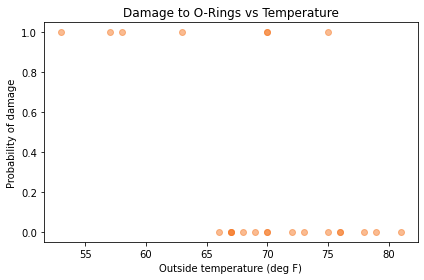

In [12]:
plot_data(data)

When the outside temperature was below 65 degrees, there was always damage to the O-rings.  When the temperature was above 65 degrees, there was usually no damage.  

Based on this figure, it seems plausible that the probability of damage is related to temperature.  If we assume this probability follows a logistic model, we can write:

$$\log O(H | x) = \beta_0 + \beta_1 x$$

where $H$ is the hypothesis that the O-rings will be damaged, $x$ is temperature, and $\beta_0$ and $\beta_1$ are the parameters we will estimate. 

For reasons I'll explain soon, I'll define $x$ to be temperature shifted by an offset so its mean is 0.

In [13]:
offset = data['Temperature'].mean()
offset

69.56521739130434

In [14]:
data['x'] = data['Temperature'] - offset

Before doing a Bayesian update, I'll use StatsModels to run a conventional (non-Bayesian) logistic regression.

In [15]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=data).fit(disp=False)
results.params

Intercept   -1.107550
x           -0.232163
dtype: float64

`results` contains a "point estimate" for each parameter, that is, a single value rather than a posterior distribution.

The intercept is about -1.1, and the estimated slope is about -0.23.
To see what these parameters mean, I'll use them to compute probabilities for a range of temperatures.

Here's the range:

In [16]:
inter = results.params['Intercept']
slope = results.params['x']
xs = np.arange(53, 83) - offset

We can use the logistic regression equation to compute log odds:

In [17]:
log_odds = inter + slope * xs

And then convert to probabilities.

In [18]:
odds = np.exp(log_odds)
ps = odds / (odds + 1)
ps.mean()

0.4155141126966855

Converting log odds to probabilities is a common enough operation that it has a name, `expit`, and SciPy provides a function that computes it.

In [19]:
from scipy.special import expit

ps = expit(inter + slope * xs)
ps.mean()

0.4155141126966854

Here's what the logistic model looks like with these estimated parameters.

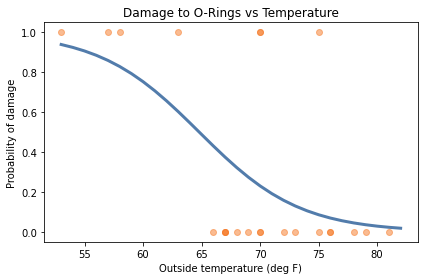

In [20]:
plt.plot(xs+offset, ps, color='C0', alpha=0.7)

plot_data(data)

At low temperatures, the probability of damage is high; at high temperatures, it drops off to near 0.

## Likelihood

Now, to do a Bayesian update, we have to compute the likelihood function for possible pairs of parameters.  

To demonstrate the process, let's assume temporarily that the parameters we just estimated are correct.
I'll use the model to compute the probability of damage for each launch temperature in the dataset.

In [21]:
xs = data['x']
ps = expit(inter + slope * xs)

`ps` contains the probability of damage for each launch, according to the model.

And `ys` contains boolean values that indicate whether damage occurred or not.

So we can use `np.where` to compute the probability of each point in the dataset.

In [22]:
ys = data['y']
likes = np.where(ys, ps, 1-ps)
likes

array([0.93924781, 0.85931657, 0.82884484, 0.60268105, 0.56950687,
       0.62527572, 0.62527572, 0.62527572, 0.67790595, 0.72637895,
       0.22996826, 0.77003174, 0.77003174, 0.22996826, 0.8419509 ,
       0.87045398, 0.91445644, 0.08554356, 0.93095593, 0.93095593,
       0.95545945, 0.96435859, 0.97729671])

For each launch where damage occurred, we choose an element from `ps`, which contains the probabilities of damage.

For each launch where damage did not occur, we choose a value from the complement of `ps`, which contains the probabilities of no damage.

The result is an array of probabilities, one for each launch.
The likelihood of the whole dataset is the product of this array.

In [23]:
likes.prod()

3.8780370902083885e-05

That's how we compute the likelihood of the data for a particular pair of parameters.
Now we have to compute the likelihood of the data for all possible pairs of parameters.
To do that, we need prior distributions.

## Prior distribution

I'll use uniform distributions for both parameters, using the point estimates from the previous section to help me choose the upper and lower bounds.

In [24]:
from utils import make_uniform

In [25]:
qs = np.linspace(-5, 1, num=61)
prior_inter = make_uniform(qs, 'Intercept')
prior_inter.head()

Intercept
-5.0    0.016393
-4.9    0.016393
-4.8    0.016393
-4.7    0.016393
-4.6    0.016393
dtype: float64

In [26]:
qs = np.linspace(-0.8, 0.1, num=91)
prior_slope = make_uniform(qs, 'Slope')
prior_slope.head()

Slope
-0.80    0.010989
-0.79    0.010989
-0.78    0.010989
-0.77    0.010989
-0.76    0.010989
dtype: float64

We can use `make_joint` to construct the joint prior distribution.

In [27]:
from utils import make_joint

joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-5.0,-4.9,-4.8,-4.7,-4.6,-4.5,-4.4,-4.3,-4.2,-4.1,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Slope,,,,,,,,,,,,,,,,,,,,,
-0.80,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,...,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018
-0.79,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,...,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018
-0.78,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,...,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018
-0.77,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,...,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018
-0.76,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,...,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018


The values of `slope` run down the rows; the values of `intercept` run across the columns.

For this problem, it will be convenient to "stack" the prior so the parameters are levels in a `MultiIndex`. 

In [28]:
from empiricaldist import Pmf

joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
-0.8   -5.0         0.00018
       -4.9         0.00018
       -4.8         0.00018
       -4.7         0.00018
       -4.6         0.00018
dtype: float64

`joint_pmf` is a `Pmf` with two levels in the index, one for each parameter.  That makes it easy to loop through possible pairs of parameters, as in the following function.

In [29]:
def likelihood_logistic(joint_pmf, data):
    """Likelihood of the data for each pair of parameters.
    
    joint_pmf: Pmf with a two-level index
    data: DataFrame with columns `x` and `y`
    
    returns: DataFrame, same shape as joint_pmf
    """
    likelihood = joint_pmf.copy()

    ys = data['y']
    xs = data['x']

    for slope, inter in joint_pmf.index:
        ps = expit(inter + slope * xs)
        likes = np.where(ys, ps, 1-ps)
        likelihood[slope, inter] = likes.prod()
        
    return likelihood

`likelihood_logistic` takes as arguments `joint_pmf`, which is a `Pmf` that represents the joint prior distribution, and `data`, which is a `DataFrame` with columns `x` and `y`.

It returns `likelihood`, which is a `Pmf` that contains the likelihood of the data for each possible pair of parameters.
To initialize `likelihood`, it makes a copy of `joint_pmf`, which is a convenient way to make sure that `likelihood` has the same type, index, and data type as `joint_pmf`.

The loop iterates through the parameters.  For each possible pair, it uses the logistic model to compute `ps`, then computes the likelihood of the data.

The last line of the loop assigns each likelihood to a row in `likelihood`.

Here's how we use this function:

In [30]:
likelihood = likelihood_logistic(joint_pmf, data)
likelihood.sum()

0.016108065211672552

## The Update

Now `likelihood` is a `Pmf` with the same index as `joint_pmf`, so we can compute the posterior distribution in the usual way.

In [31]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.9018312397176286e-06

Because we used a uniform prior, the parameter pair with the highest likelihood is also the pair with maximum posterior probability:

In [32]:
pd.Series(posterior_pmf.max_prob(),
          index=['slope', 'inter'])

slope   -0.23
inter   -1.10
dtype: float64

So we can confirm that the results of the Bayesian update are consistent with the maximum likelihood estimate computed by StatsModels:

In [33]:
results.params

Intercept   -1.107550
x           -0.232163
dtype: float64

They are approximately the same, within the precision of the grid we're using.

If we unstack the posterior `Pmf` we can make a contour plot of the joint posterior distribution.

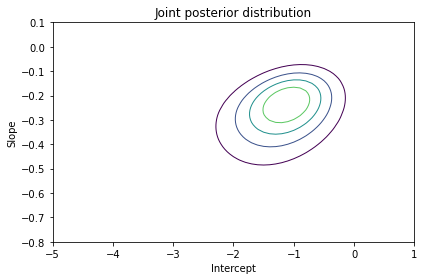

In [34]:
from utils import plot_contour

joint_posterior = posterior_pmf.unstack()
plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

The ovals in the contour plot are aligned along a diagonal, which indicates that there is some correlation between `slope` and `inter` in the posterior distribution.

But the correlation is weak, which is one of the reasons we subtracted off the mean launch temperature when we computed `x`; centering the data minimizes the correlation between the parameters.

To see why this matters, go back and set `offset=60` and run the analysis again.  You'll have to adjust the prior distribution of `intercept`.

The slope should be the same, but the intercept will be different.  And if you plot the joint distribution, the contours you get will be elongated, indicating stronger correlation between the estimated parameters.  

In theory, this correlation is not a problem, but in practice it is.  With uncentered data, the posterior distribution is more spread out, so it's harder to cover with the joint prior distribution.
Centering the data maximizes the precision of the estimates; with uncentered data, we have to do more computation to get the same precision.

##  Marginal distributions

Finally, we can extract the marginal distributions.
Here's the posterior distribution of `inter`.

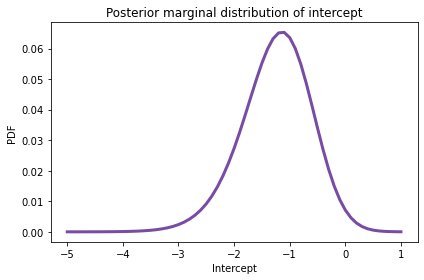

In [35]:
from utils import marginal

marginal_inter = marginal(joint_posterior, 0)
marginal_inter.plot(color='C4')

decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

And here's the posterior distribution of `slope`.

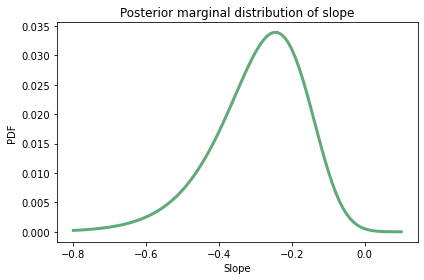

In [36]:
marginal_slope = marginal(joint_posterior, 1)
marginal_slope.plot(color='C2')

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

Here are the posterior means.

In [37]:
pd.Series([marginal_inter.mean(), marginal_slope.mean()],
          index=['slope', 'inter'])

slope   -1.250178
inter   -0.289804
dtype: float64

Like the MAP, the posterior means are close to the parameters we estimated with StatsModels.

In [38]:
results.params

Intercept   -1.107550
x           -0.232163
dtype: float64

Both marginal distributions are moderately skewed, so the posterior means are somewhat different from the most likely values.

## Transforming Distributions

Let's interpret these parameters.  Recall that the intercept is the log odds of the hypothesis when $x$ is 0, which is when temperature is about 70 degrees F (the value of `offset`).

So we can interpret the quantities in `marginal_inter` as log odds.

To convert them to probabilities, I'll use the following function, which transforms the quantities in a `Pmf` by applying a given function:

In [39]:
def transform(pmf, func):
    """Transform the quantities in a Pmf.
    
    pmf: Pmf object
    func: function object
    
    returns: Pmf
    """
    ps = pmf.ps
    qs = func(pmf.qs)
    return Pmf(ps, qs)

If we call `transform` and pass `expit` as a parameter, it transforms the log odds in `marginal_inter` into probabilities and returns the posterior distribution of `inter` expressed in terms of probabilities.

In [40]:
marginal_probs = transform(marginal_inter, expit)

Here's the posterior distribution for the probability of damage at 70 degrees F.

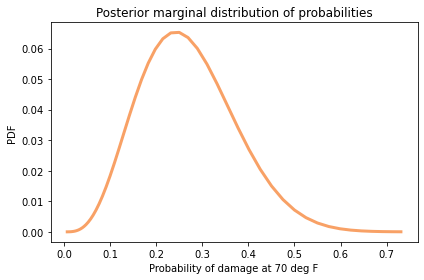

In [41]:
marginal_probs.plot(color='C1')

decorate(xlabel='Probability of damage at 70 deg F',
         ylabel='PDF',
         title='Posterior marginal distribution of probabilities')

The mean of this distribution is about 24%, which is the probability of damage at 70 degrees F, according to the model.

In [42]:
mean_prob = marginal_probs.mean()
mean_prob

0.24011003476381537

This result shows the second reason I defined `x` to be zero when temperature is 70 degrees F; this way, the intercept corresponds to the probability of damage at a relevant temperature, rather than 0 degrees F.

Now let's look more closely at the estimated slope.  In the logistic model, the parameter $\beta_1$ is the log of the likelihood ratio.  

So we can interpret the quantities in `marginal_slope` as log likelihood ratios, and we can use `exp` to transform them to likelihood ratios (also known as Bayes factors).

In [43]:
marginal_lr = transform(marginal_slope, np.exp)

The result is the posterior distribution of likelihood ratios; here's what it looks like.

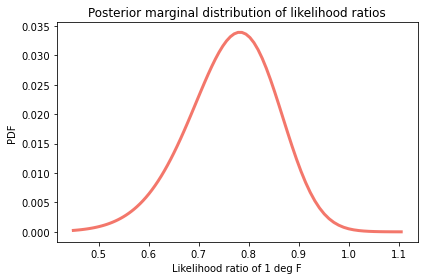

In [44]:
marginal_lr.plot(color='C3')

decorate(xlabel='Likelihood ratio of 1 deg F',
         ylabel='PDF',
         title='Posterior marginal distribution of likelihood ratios')

The mean of this distribution is about 0.75:

In [45]:
mean_lr = marginal_lr.mean()
mean_lr

0.7542860354699876

Which means that each additional degree Fahrenheit provides evidence against the possibility of damage, with a likelihood ratio (Bayes factor) of 0.75.

Notice:

* I computed the posterior mean of the probability of damage at 70 deg F by transforming the marginal distribution of the intercept to the marginal distribution of probability, and then computing the mean.

* I computed the posterior mean of the likelihood ratio by transforming the marginal distribution of slope to the marginal distribution of likelihood ratios, and then computing the mean.

This is the correct order of operations, as opposed to computing the posterior means first and then transforming them.  

To see the difference, let's compute both values the other way around. 
Here's the posterior mean of `marginal_inter`, transformed to a probability, compared to the mean of `marginal_probs`.

In [46]:
expit(marginal_inter.mean()), marginal_probs.mean()

(0.2226693947269983, 0.24011003476381537)

And here's the posterior mean of `marginal_slope`, transformed to a likelihood ratio, compared to the mean `marginal_lr`.

In [47]:
np.exp(marginal_slope.mean()), marginal_lr.mean()

(0.7484101215875322, 0.7542860354699876)

In this example, the differences are not huge, but they can be.
As a general rule, transform first, then compute summary statistics.

## Predictive distributions

In the logistic model, the parameters are interpretable, at least after transformation.  But often what we care about are predictions, not parameters.  In the Space Shuttle problem, the most important prediction is, "What is the probability of O-ring damage if the external temperature is 31 degrees F?"

To make that prediction, I'll draw a sample of parameter pairs from the posterior distribution.

In [48]:
np.random.seed(17)

In [49]:
sample = posterior_pmf.sample(101)
sample.shape

(101,)

The result is an array of 101 tuples, each representing a possible pair of parameters.

In [50]:
sample.dtype

dtype('O')

In [51]:
type(sample[0])

tuple

To generate predictions, I'll use a range of temperatures from 31 degrees F (the temperature when the Challenger launched) to 82 degrees F (the highest observed temperature).

In [52]:
temps = np.arange(31, 83)
xs = temps - offset

The following loop uses `xs` and the sample of parameters to construct an array of predicted probabilities.

In [53]:
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)

The result has one column for each value in `xs` and one row for each element of `sample`.  To get a quick sense of what the predictions look like, we can loop through the rows and plot them.

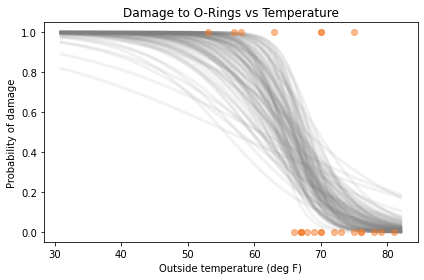

In [54]:
for ps in pred:
    plt.plot(temps, ps, color='gray', alpha=0.1)
    
plot_data(data)

The overlapping lines in this figure give a sense of the most likely value at each temperature and the degree of uncertainty.

To quantify the central tendency, I'll compute the median in each column, and to quantify the uncertainty, I'll compute a 90% credible interval.

`np.percentile` computes the given percentiles; with the argument `axis=0`, it computes them for each column.

In [55]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(52,)

The result is three arrays containing predicted probabilities for the lower bound of the 90% CI, the median, and the upper bound of the CI.

Here's what they look like:

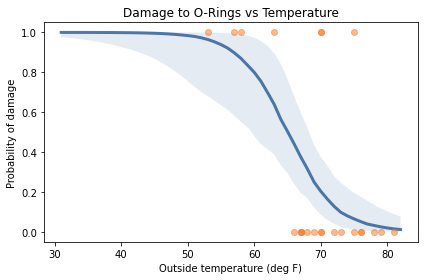

In [56]:
plt.fill_between(temps, low, high, alpha=0.1)
plt.plot(temps, median, color='C0')

plot_data(data)

According to these results, the probability of damage to the O-rings at 80 degrees F is near 2%, but there is some uncertainty about that prediction; the upper bound of the CI is around 10%.

In [57]:
low = pd.Series(low, temps)
median = pd.Series(median, temps)
high = pd.Series(high, temps)

In [85]:
t = 80
print(median[t], (low[t], high[t]))

0.01942193561186948 (0.0008953578714056307, 0.1025170297002024)


At 60 degrees, the probability of damage is near 80%, but the CI is even wider, from 48% to 97%.

In [86]:
t = 60
print(median[t], (low[t], high[t]))

0.8001059246534677 (0.4815301469778966, 0.9731769503769349)


But the primary goal of the model is to predict the probability of damage at 31 degrees F, and the answer is at least 97%, and more likely to be more than 99.9%.

In [84]:
t = 31
print(median[t], (low[t], high[t]))

0.9999002365290406 (0.9761882957987359, 0.9999999881852023)


One conclusion we might draw from these results is this:  If the people responsible for the Challenger launch had taken into account all of the data, and not just the seven damage incidents, they could have predicted that the probability of damage at 31 degrees F was nearly certain.  If they had, it seems likely they would have postponed the launch.

At the same time, if they considered the previous figure, they might have realized that the model makes predictions that extend far beyond the data.  When we extrapolate like that, we have to remember not just the uncertainty quantified by the model, which we expressed as a credible interval; we also have to consider the possibility that the model itself is unreliable.

This example is based on a logistic model, which assumes that each additional degree of temperature contributes the same amount of evidence in favor of (or against) the possibility of damage.  Within a narrow range of temperatures, that might be a reasonable assumption, especially if it is supported by data.  But over a wider range, and beyond the bounds of the data, reality has no obligation to stick to the model.

## Generational Changes

As a second example of logistic regression, we'll use data from the [General Social Survey](https://gss.norc.org/) (GSS) to describe generational changes in support for legalization of marijuana.

Since 1972 the GSS has surveyed a representative sample of adults in the U.S., asking about issues like "national spending priorities, crime and punishment, intergroup relations, and confidence in institutions".

I have selected a subset of the GSS data, resampled it to correct for stratified sampling, and made the results available in an HDF file.

In [61]:
# Load the data file

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/gss_eda.hdf5

We can use Pandas to load the data.

In [62]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 169)

The result is a `DataFrame` with one row for each respondent and one column for each variable.

The primary variable we'll explore is `grass`, which encodes each respondent's answer to this question ([details here](https://gssdataexplorer.norc.org/variables/285/vshow)):

> "Do you think the use of marijuana should be made legal or not?"

This question was asked during most years of the survey starting in 1973, so it provides a useful view of changes in attitudes over almost 50 years.

Here are is the distributions of responses:

In [63]:
gss['grass'].value_counts(dropna=False)

NaN    27268
2.0    25662
1.0    11884
Name: grass, dtype: int64

The value 1.0 represents "yes"; 2.0 represents "no"; `NaN` represents a small number of respondents who did not respond or said "I don't know", and a larger number who were randomly not asked the question.

To explore generational changes in the responses, we will look at the level of support for legalization as a function of birth year, which is encoded in a variable called `cohort`.  Here's a description of this variable.

In [64]:
gss['cohort'].describe()

count    64586.000000
mean      1948.846069
std         21.262659
min       1883.000000
25%       1934.000000
50%       1951.000000
75%       1964.000000
max       2000.000000
Name: cohort, dtype: float64

The oldest GSS respondent was born in 1883; the youngest was born in 2000.

Before we analyze this data, I will select the subset of respondents with valid data for `grass` and `cohort`:

In [65]:
valid = gss.dropna(subset=['grass', 'cohort']).copy()
valid.shape

(37427, 169)

There are about 37,000 respondents with the data we need.

I'll recode the values of `grass` so `1` means yes and `0` means no.

In [66]:
valid['y'] = valid['grass'].replace(2, 0)
valid['y'].value_counts()

0.0    25572
1.0    11855
Name: y, dtype: int64

Now, for this problem, I'm going to represent the data in a different format.  Rather than one row for each respondent, I am going to group the respondents by birth year and record the number of respondents in each group, `count`, and the number who support legalization, `sum`.

In [67]:
data = valid.groupby('cohort')['y'].agg(['sum', 'count'])
data

,sum,count
cohort,,
1884.0,0.0,1
1886.0,0.0,3
1887.0,1.0,9
1888.0,0.0,3
1889.0,1.0,14
...,...,...
1996.0,40.0,47
1997.0,28.0,41
1998.0,11.0,17


Here's what the results look like:

In [68]:
def plot_data(data):
    """Plot the fraction of yes responses.
    
    data: DataFrame with columns `sum` and `count`
    """
    fraction = data['sum'] / data['count']
    plt.plot(data.index, fraction, 'o', color='C1',
             label='GSS data', alpha=0.3)
    
    decorate(xlabel='Year of birth',
             ylabel='Percent in favor',
             title='Support for legal marijuana vs cohort')

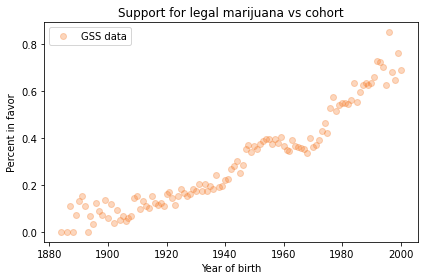

In [69]:
plot_data(data)

There is a strong relationship between birth year and support for legalization.  People born before 1910 are the least likely to say "yes"; people born after 1990 are the most likely. 

There are substantial departures from the long-term trend for people born in the 1950s and late 1960s.  If you want to conjecture about the causes, it might help to think about what was happening when each group turned 18.  People born in 1950 turned 18 during [the counterculture of the 1960s](https://en.wikipedia.org/wiki/Counterculture_of_the_1960s).  People born in the late 1960s turned 18 during the "[Just Say No](https://en.wikipedia.org/wiki/Just_Say_No)" era of the War on Drugs and the peak in the AIDS epidemic in the U.S.

## Point estimates

I'll use StatsModels again to generate point estimates for the slope and intercept of a logistic model.

As we did with the previous problem, I'll center the values of the explanatory variable so the mean is 0.

In [70]:
offset = valid['cohort'].mean()
valid['x'] = valid['cohort'] - offset

Here are the results from StatsModels.

In [71]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=valid).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.582717
         Iterations 5


Intercept   -0.849094
x            0.031691
dtype: float64

To visualize the results, I'll use these parameters to estimate the probability of support in each cohort.

In [72]:
inter = -0.85
slope = 0.032

I'll shift the birth years in `data` by `offset`.

In [73]:
data['x'] = data.index - offset
data.head()

,sum,count,x
cohort,,,
1884.0,0.0,1,-64.724243
1886.0,0.0,3,-62.724243
1887.0,1.0,9,-61.724243
1888.0,0.0,3,-60.724243
1889.0,1.0,14,-59.724243


And use `expit` to compute the probabilities.

In [74]:
ps = expit(inter + slope * data['x'])
ps

cohort
1884.0    0.051117
1886.0    0.054312
1887.0    0.055979
1888.0    0.057694
1889.0    0.059459
            ...   
1996.0    0.659895
1997.0    0.667039
1998.0    0.674108
1999.0    0.681098
2000.0    0.688008
Name: x, Length: 116, dtype: float64

Here's what the model looks like with the data.

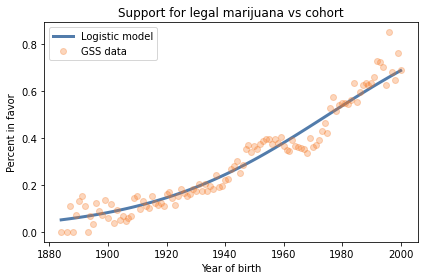

In [75]:
ps.plot(color='C0', label='Logistic model')

plot_data(data)

With these parameters, the model captures the long term trend in the data.

## Computing likelihoods

Before we do the Bayesian update, let's compute the probability of the data with the estimated parameters.

From the data, we know how many people there are in each group and how many of them support legalization.  From the model, we have an estimate for the probability of support in each group.

So we can use the binomial distribution to compute the probability of the data given the estimated probabilities.

In [76]:
from scipy.stats import binom

ks = data['sum']
ns = data['count']
likes = binom.pmf(ks, ns, ps)
likes.shape

(116,)

For each group `likes` contains the probability of the outcome, `k`, given the group size, `n`, and the estimated probability, `p`.

The likelihood of the data is the product of these likelihoods:

In [77]:
likes.prod()

1.374180525164937e-209

This likelihood is very small, for two reasons:

* The dataset is large, which means that there are many possible outcomes, so the probability of *any* particular outcome is small.

* The data deviate substantially from the model, so the probability of *this* particular outcome is small.

In theory, it's not a problem if the likelihood of the data is small.  We might not get a model that fits the data perfectly, but we'll get the parameters that come as close as possible.

However, in practice small likelihoods can be problematic.  With floating-point numbers, the smallest positive number we can represent is about `1e-1021`.

In [78]:
import sys
sys.float_info.min_exp

-1021

Any number smaller than that "underflows"; that is, it gets rounded down to 0.  When that happens, we lose the ability to distinguish between parameters that make the model fit the data or not.  In the worst case, if all likelihoods underflow, all probabilities in the posterior distribution would be 0.

In this example, the likelihoods are big enough that we can still do a Bayesian update, so we'll do that next.
Then I will demonstrate a trick we can use to avoid underflow: computing likelihoods under a log transformation.

## The update

I'll use uniform priors for the parameters, with locations centered around the point estimates.

In [79]:
prior_inter = make_uniform(-0.95, -0.75, 51, 'Intercept')

TypeError: make_uniform() takes from 1 to 2 positional arguments but 4 were given

In [ ]:
prior_slope = make_uniform(0.025, 0.035, 51, 'Slope')

I'll make a joint prior.

In [ ]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

And stack it into a `Pmf` with a two-column index.

In [ ]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Here's the update, using the binomial distribution to compute the likelihood of the data in each group.

In [ ]:
likelihood = joint_pmf.copy()

xs = data['x']
ks = data['sum']
ns = data['count']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood.loc[slope, inter] = likes.prod()

Again, the likelihoods are small.

In [ ]:
likelihood.sum()

But we can do the update in the usual way.

In [ ]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

And there are enough non-zero elements to get a useful posterior distribution.

Here's what it looks like.

In [ ]:
joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

We can confirm that the parameters with maximum posterior probability are consistent with the point estimates.

In [ ]:
posterior_pmf.max_prob(), results.params.values[::-1]

Here are the means of the marginal distributions.

In [ ]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

Recall that the intercept indicates the log odds of the hypothesis at `x=0`.
To make the distribution of intercepts easier to interpret, I'll use `expit` to transform the values to probabilities.

In [ ]:
marginal_probs = transform(marginal_inter, expit)

In [ ]:
marginal_probs.plot()
decorate(xlabel='Probability at x=0',
         ylabel='PDF',
         title='Posterior distribution of intercept in terms of probability')

The mean of this distribution is about 24%, which is the predicted probability of supporting legalization for someone born around 1949.

In [ ]:
marginal_probs.mean(), offset

The estimated slope is the log of the likelihood ratio for each additional year of birth.  To interpret slopes as likelihood ratios, we can use `np.exp` to transform the values in the posterior distribution.

In [ ]:
marginal_lr = transform(marginal_inter, np.exp)

In [ ]:
marginal_lr.plot()

decorate(xlabel='Likelihood ratio of each additional year',
         ylabel='PDF',
         title='Posterior distribution of slope in terms of likelihood ratio')

The mean of this distribution is about 0.43, which indicates that each additional year is evidence that the respondent will say "yes", with a a likelihood ratio (or Bayes factor) of 0.43.

In [ ]:
marginal_lr.mean()

Later we will use the joint posterior distribution to generate predictions, but first I'll show how to compute likelihoods under a log transform.

## Log likelihood

Because of the problem of underflow, many likelihood computations are done under a log transform.  That's why the distributions in SciPy, including `binom`, provide functions to compute logarithms of PMFs and PDFs.

Here's a loop that computes the log likelihood of the data for each pair of parameters in `joint_pmf`: 

In [ ]:
log_likelihood = joint_pmf.copy()

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    log_likes = binom.logpmf(ks, ns, ps)
    log_likelihood.loc[slope, inter] = log_likes.sum()

`log_likes` contains the logarithms of the binomial PMFs for each group, so it sum is the logarithm of the product of the likelihoods.

Since the likelihoods are small, their logarithms are negative.  The smallest (most negative) is about -610; the largest (least negative) is about -480.

In [ ]:
log_likelihood.min(), log_likelihood.max()

So the log likelihoods are comfortably with the range we can represent with floating-point numbers.

However, before we can do the update, we have to convert the logarithms back to a linear scale.  To do that while minimizing underflow, I am going to shift the logs up toward zero.

In [ ]:
shifted = log_likelihood - log_likelihood.max()
likelihood2 = np.exp(shifted)

After subtracting away the largest element in `log_likelihood`, the range of values in the result is from -127 to 0.

In [ ]:
shifted.min(), shifted.max()

In [ ]:
likelihood2.min(), likelihood2.max()

After applying `np.exp`, the range of likelihoods is from about `7e-56` to 0.

Now we can use them as likelihoods in a Bayesian update.

In [ ]:
posterior2_pmf = joint_pmf * likelihood2
posterior2_pmf.normalize()

Adding a constant to the `log_likelihood` is the same as multiplying a constant by `likelihood`.  We can do that without affecting the results because we have to normalize the posterior probabilities, so the multiplicative constant gets normalized away.

Here's the joint distribution we get using log likelihoods.

In [ ]:
joint_posterior2 = posterior2_pmf.unstack()

plot_contour(joint_posterior2)
decorate(title='Joint posterior distribution')

The parameters with maximum posterior probability are the same.

In [ ]:
posterior_pmf.max_prob(), posterior2_pmf.max_prob()

And so are the posterior means.

In [ ]:
marginal2_inter = marginal(joint_posterior2, 0)
marginal2_slope = marginal(joint_posterior2, 1)

marginal2_inter.mean(), marginal2_slope.mean()

In [ ]:
marginal_inter.mean(), marginal_slope.mean()

In this example, we can compute the posterior distribution either way, using likelihoods or log likelihoods.  But if there were more data, the likelihoods would underflow and it would be necessary to use log likelihoods.

## Making predictions

As we did with the previous example, we can use the posterior distribution of the parameters to generate predictions, which we can use to see whether the model fits the data and to extrapolate beyond the data.

I'll start with a sample from the posterior distribution.

In [ ]:
np.random.seed(42)

In [ ]:
sample = posterior_pmf.sample(101)

And a range of `xs` that extends 20 years past the observed data.

In [ ]:
xs = np.arange(1880, 2021) - offset

We can use the sampled parameters to predict probabilities for each group.

In [ ]:
ps = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    ps[i] = expit(inter + slope * xs)
    
ps.shape

But that only accounts for uncertainty about the parameters.

We also have to account for variability in the size of the groups.  Here's the distribution of group size, dropping the groups smaller than 20.

In [ ]:
not_small = (data['count'] >= 20)
counts = data.loc[not_small, 'count']
counts.describe()

To simulate variation in group size, I'll use `np.random.choice` to resample the group sizes; that is, I'll draw from `counts` a sample with the same length as `xs`, sampling with replacement.

In [ ]:
np.random.choice(counts, len(xs), replace=True)

Now, even if we know how many people are in each group and their probability of saying "yes", there is still uncertainty in the outcome.  We can use the binomial distribution to simulate this (final) source of uncertainty.

Putting it all together, the following loop combines these sources of uncertainty to generate predictive distributions for each group.

In [ ]:
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    ps = expit(inter + slope * xs)
    ns = np.random.choice(counts, len(xs), replace=True)
    ks = binom(ns, ps).rvs(len(xs))
    pred[i] = ks / ns
    
pred.shape

The result is an array with one row for each pair of parameters in the sample and one column for each value in `xs`.

Now we can use `np.percentile` to compute percentiles in each column.

In [ ]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

And use them to plot a 90% credible interval for the predictions.

In [ ]:
plt.fill_between(xs+offset, low, high, alpha=0.2)
plt.plot(xs+offset, median, color='C0', alpha=0.5)

plot_data(data)

The model fits the long-term trend of the data, with most data points falling within the 90% credible interval despite the apparent deviations from the trend.

And it predicts that people born between 2000 and 2020 will be more likely to support legalizing marijuana, or they will when they are old enough to be respondents in the General Social Survey.

## Empirical Bayes

In this chapter I used StatsModels to compute the parameters that maximize the probability of the data, and then used those estimates to choose the bounds of the uniform prior distributions.

It might have occurred to you that this process uses the data twice, once to choose the priors and again to do the update.  And if it occurred to you, it might have bothered you.  And in that case you would not be alone.

The process I used is an example of what's called the [Empirical Bayes method](https://en.wikipedia.org/wiki/Empirical_Bayes_method), although I don't think that's a particularly good name for it.

Although it might seem problematic to use the data twice, in these examples, it is not.  To see why, consider an alternative: instead of using the estimated parameters to choose the bounds of the prior distribution, I could have used uniform distributions with much wider ranges.  

In that case, the results would be the same; the only difference is that I would spend more time computing likelihoods for parameters where the posterior probabilities are negligibly small.

So you can think of this version of Empirical Bayes as an optimization that minimizes computation by putting the prior distributions where the likelihood of the data is non-negligible.

But this optimization doesn't affect the results, so it doesn't "double-count" the data.

## Summary

So far we have seen three ways to represent degrees of confidence in a hypothesis: probability, odds, and log odds.  When we write Bayes's Rule in terms of log odds, a Bayesian update is the sum of the prior and the likelihood; in this sense, Bayesian statistics is the arithmetic of hypotheses and evidence.

This form of Bayes Theorem is also the foundation of logistic regression, which we used to infer parameters and make predictions.  In the Space Shuttle problem, we modeled the relationship between temperature and the probability of damage, and showed that the Challenger disaster might have been predictable.  But this example is also a warning about the hazards of using a model to extrapolate far beyond the data.

We also modeled generational changes in support for legalizing marijuana, which was less than 10% among people born in the 1890s, and is nearly 80% among people born in the 1990s.
Because the dataset we used is large, the total probability of the data is very small, which can run into the limits of floating-point arithmetic.  We can avoid this problem by computing likelihoods under a logarithmic transformation.

In the exercises below you'll have a chance to practice the material in this chapter, using log odds to evaluate a political pundit and using logistic regression to model diagnosis rates for Attention Deficit Hyperactivity Disorder (ADHD).

In the next chapter we'll move from logistic regression to linear regression, which we will use to model changes over time in temperature, snowfall, and the marathon world record.

## Exercises

**Exercise:** Suppose a political pundit claims to be able to predict the outcome of elections, but instead of picking a winner, they give each candidate a probability of winning.  With that kind of prediction, it can be hard to say whether it is right or wrong. 

For example, suppose they pundit says that Alice has a 70% chance of beating Bob, and then Bob wins the election.  Does that mean the pundit was wrong?

One way to answer this question is to consider two hypotheses:

* `H`: The pundit's algorithm is legitimate; the probabilities it produces are correct in the sense that they accurately reflect the candidates' probabilities of winning.

* `not H`: The pundit's algorithm is bogus; the probabilities it produces are random values with a mean of 50%.

If the pundit says Alice has a 70% chance of winning, and she does, that provides evidence in favor of `H` with likelihood ratio 70/50.

If the pundit says Alice has a 70% chance of winning, and she loses, that's evidence against `H` with a likelihood ratio of 50/30.

Suppose we start with some confidence in the algorithm, so the prior odds are 4 to 1.  And suppose the pundit generates predictions for three elections:

* In the first election, the pundit says Alice has a 70% of winning and she does.

* In the second election, the pundit says Bob has a 30% chance of winning and he does.

* In the third election, the pundit says Carol has an 90% chance of winning and she does.

What is the log likelihood ratio for each of these outcomes?  Use the log-odds form of Bayes's Rule to compute the posterior log odds for `H` after these outcomes.  In total, do these outcomes increase or decrease your confidence in the pundit?

If you are interested in this topic, you can [read more about it in this blog post](http://allendowney.blogspot.com/2016/11/why-are-we-so-surprised.html).

In [ ]:
# Solution

prior_log_odds = np.log(4)
prior_log_odds

In [ ]:
# Solution

lr1 = np.log(7/5)
lr2 = np.log(3/5)
lr3 = np.log(9/5)

lr1, lr2, lr3

In [ ]:
# Solution

posterior_log_odds = prior_log_odds + lr1 + lr2 + lr3
posterior_log_odds

**Exercise:** The GSS dataset we used to explore generational changes contains more than 100 other variables related to the attitudes and beliefs of the respondents.  You can [read about these variables here](https://gssdataexplorer.norc.org/projects/52787).  Choose one and run an analysis similar to what we did with `grass`.

How well does the logistic model describe the long-term trend for the variable you chose?

**Exercise:**  An article in the New England Journal of Medicine reports results from a study that looked at the diagnosis rate of Attention Deficit Hyperactivity Disorder (ADHD) as a function of birth month: ["Attention Deficit–Hyperactivity Disorder and Month of School Enrollment"](https://www.nejm.org/doi/10.1056/NEJMoa1806828).

They found that children born in June, July, and August were substantially more likely to be diagnosed with ADHD, compared to children born in September, but only in states that use a September cutoff for children to enter kindergarten.  In these states, children born in August start school almost a year younger than children born in September.  The authors of the study suggest that the cause is "age-based variation in behavior that may be attributed to ADHD rather than to the younger age of the children". 

The paper includes this figure:

<img width="500" src="https://www.nejm.org/na101/home/literatum/publisher/mms/journals/content/nejm/2018/nejm_2018.379.issue-22/nejmoa1806828/20190131/images/img_xlarge/nejmoa1806828_f1.jpeg">

In my opinion, this representation of the data does not show the effect as clearly as it could, but the figure includes the raw data, so we can analyze it ourselves.

However, there is an error in this figure, confirmed by personal correspondence:

>The May and June [diagnoses] are reversed. May should be 317 (not 287) and June should be 287 (not 317).

So here is the corrected data, where `n` is the number of children born in each month, starting with January, and `k` is the number of children diagnosed with ADHD.

In [ ]:
n = np.array([32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617])

k = np.array([265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243])

First, I'm going to "roll" the data so it starts in September rather than January.

In [ ]:
x = np.arange(12)
n = np.roll(n, -8)
k = np.roll(k, -8)

And I'll put it in a `DataFrame` with one row for each month and the diagnosis rate per 10,000.

In [ ]:
data = pd.DataFrame(dict(x=x, k=k, n=n))
data['rate'] = data['k'] / data['n'] * 10000
data

Here's what the diagnosis rates look like.

In [ ]:
def plot_data(data):
    plt.plot(data['x'], data['rate'], 'o', 
         color='C1', alpha=0.5)
    
    plt.axvline(5.5, color='gray', alpha=0.2)
    plt.text(6, 64, 'Younger than average')
    plt.text(5, 64, 'Older than average', horizontalalignment='right')

    decorate(xlabel='Birth date, months after cutoff',
             ylabel='Diagnosis rate per 10,000')

In [ ]:
plot_data(data)

For the first 9 months, from September to May, we see what we would expect if some of the excess diagnoses are due to "age-based variation in behavior".  For each month of difference in age, we see an increase in the number of diagnoses.

This pattern breaks down for the last three months, June, July, and August.  This might be explained by random variation, but it also might be due to parental manipulation; if some parents hold back children born near the deadline, the observations for these month would include a mixture of children who are relatively old for their grade and therefore less likely to be diagnosed.

Unfortunately, the dataset includes only month of birth, not year, so we don't know the actual ages of these students when they started school.  However, we can use the first nine months to estimate the effect of age on diagnosis rate; then we can think about what to do with the other three months.

Use the methods in this chapter to estimate the probability of diagnosis as a function of birth month.  Start with the following prior distributions.

In [ ]:
prior_inter = make_uniform(-5.2, -4.6, 51, 'Intercept')

In [ ]:
prior_slope = make_uniform(0.0, 0.08, 51, 'Slope')

1. Make a joint prior distribution and update it using the data for the first nine months.

2. Then draw a sample from the posterior distribution and use it to compute the median probability of diagnosis for each month and a 90% credible interval.

3. As a bonus exercise, do a second update using the data from the last three months, but treating the observed number of diagnoses as a lower bound on the number of diagnoses there would be if no children were kept back.

In [ ]:
# Solution

joint = make_joint(prior_inter, prior_slope)
joint.head()

In [ ]:
# Solution

joint_pmf = Pmf(joint.stack())
joint_pmf.head()

In [ ]:
# Solution

num_legit = 9
data1 = data.loc[0:num_legit]
data2 = data.loc[num_legit+1:]
data1

In [ ]:
# Solution

data2

In [ ]:
# Solution

likelihood1 = joint_pmf.copy()

xs = data1['x']
ks = data1['k']
ns = data1['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood1.loc[slope, inter] = likes.prod()

likelihood1.sum()

In [ ]:
# Solution

# This update uses the binomial survival function to compute
# the probability that the number of cases *exceeds* `ks`.

likelihood2 = joint_pmf.copy()

xs = data2['x']
ks = data2['k']
ns = data2['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.sf(ks, ns, ps)
    likelihood2.loc[slope, inter] = likes.prod()

likelihood2.sum()

In [ ]:
# Solution

posterior_pmf = joint_pmf * likelihood1
posterior_pmf.normalize()

In [ ]:
# Solution

posterior_pmf.max_prob()

In [ ]:
# Solution

posterior_pmf = joint_pmf * likelihood1 * likelihood2
posterior_pmf.normalize()

In [ ]:
# Solution

posterior_pmf.max_prob()

In [ ]:
# Solution

joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

In [ ]:
# Solution

marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

In [ ]:
# Solution

marginal_inter.plot()
decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [ ]:
# Solution

marginal_slope.plot()

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [ ]:
# Solution

sample = posterior_pmf.sample(101)
xs = data['x']
ps = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    ps[i] = expit(inter + slope * xs)
    
ps.shape

In [ ]:
# Solution

low, median, high = np.percentile(ps, [2.5, 50, 97.5], axis=0)
median

In [ ]:
# Solution

plt.fill_between(xs, low*10000, high*10000, alpha=0.2)
plt.plot(xs, median*10000, alpha=0.5)

plot_data(data)